# Выполнил: Филоненко Никита Дмитриевич

-----

QR-код (ссылка на репозиторий с проектом)

[Решение на GitHub](https://github.com/nikfilonenko/video_gen_trends_analysis)

![](../../assets/qr-code.png)

# Оглавление

[Описание тестового задания](#0.1)
1. [Сбор данных через arXiv API](#01)
2. [EDA](#02)
    - [Получение общего представления о данных](#02.1)
    - [Предобработка текста для анализа](#02.2)
3.


## Описание тестового задания <a name="0.1"></a>

Задача - выделить основные тренды в видео генерации в 2024 году.

1. Получить метаданные статей с arXiv (любым способом) по теме “видео генерация”, выпущенных в 2024 году.
    
2. Написать код для выделения основных тем/трендов.
    
- Будет плюсом, если каждая тема будет представлена связным словосочетанием/предложением

3. Представить визуализацию результатов.
    


# Решение

### Импортируем необходимые модули 

In [1]:
import pandas as pd
import numpy as np
import arxiv
import matplotlib.pyplot as plt
import seaborn as sns

для получения метаданных статей из arXiv будем использовать его API, вместо написания парсера

поскольку:

- у arXiv нет жестких ограничений, платных тарифов

- API предоставляет доступ ко всему необходимому для выполнения данного задания

- лимит в 10 000 результатов на запрос – этого более чем достаточно

- соответственно нет жесткого rate limit, если не спамить слишком часто

- использование API избавит от лишней предобработки текста (например html теги)



## 1. Сбор данных через arXiv API <a name="01"></a>

будем использовать библиотеку arxiv, которая предоставляет удобный высокоуровневый интерфейс для работы с API arXiv

In [174]:
query = (
    'all:video generation OR all:video synthesis OR '
    'all:diffusion video OR all:GAN video OR '
    'all:text-to-video OR all:image-to-video OR '
    'all:scene generation '
    'AND submittedDate:[20240101 TO 20241231]'
)

search = arxiv.Search(
    query=query,
    max_results=150000,
    sort_by=arxiv.SortCriterion.Relevance,
    sort_order=arxiv.SortOrder.Ascending
)

выполним ленивую загрузку метаданных, создав генератор через `client.results(search)`, благодаря чему с экономим на оперативной памяти и времени начальной загрузки данных

также, учитывая тот факт, что arXiv API не позволяет фильтровать запросы по конкретному году (в нашем случае — 2024), при формировании набора данных дополнительно проверим соответствие года публикации, чтобы гарантировать включение только статей, опубликованных за 2024 год

In [175]:
client = arxiv.Client(
    page_size=500,
    delay_seconds=5,
    num_retries=5
)

papers = []

current_year = 2024

try:
    for result in client.results(search):
        if result.published.year == current_year:
            papers.append({
                "title": result.title,
                "abstract": result.summary,
                "published": result.published,
                "authors": [a.name for a in result.authors],
                "url": result.entry_id
            })
except arxiv.UnexpectedEmptyPageError:
    print("Достигнут предел доступных результатов")

df = pd.DataFrame(papers)

Достигнут предел доступных результатов


In [203]:
from colorama import Fore, Style

print(f"Сколько всего статей 2024 года получено: {Fore.GREEN}{len(df)}{Style.RESET_ALL}")

Сколько всего статей 2024 года получено: 2100


Итак, собранные имеют следующую структуру:

- `title` - заголовок статьи
- `abstract` - аннотация статьи
- `published` - полная дата и время публикации статьи
- `authors` - списки авторов статей
- `url` - ссылка на статью в arXiv 

In [137]:
df

,title,abstract,published,authors,url
0,Video to Video Generative Adversarial Network ...,The development of sophisticated models for vi...,2024-10-28 01:35:10+00:00,"[Yintai Ma, Diego Klabjan, Jean Utke]",http://arxiv.org/abs/2410.20657v1
1,Contrastive Sequential-Diffusion Learning: Non...,Generated video scenes for action-centric sequ...,2024-07-16 15:03:05+00:00,"[Vasco Ramos, Yonatan Bitton, Michal Yarom, Id...",http://arxiv.org/abs/2407.11814v3
2,ReCapture: Generative Video Camera Controls fo...,"Recently, breakthroughs in video modeling have...",2024-11-07 18:59:45+00:00,"[David Junhao Zhang, Roni Paiss, Shiran Zada, ...",http://arxiv.org/abs/2411.05003v1
3,"StreamingT2V: Consistent, Dynamic, and Extenda...",Text-to-video diffusion models enable the gene...,2024-03-21 18:27:29+00:00,"[Roberto Henschel, Levon Khachatryan, Daniil H...",http://arxiv.org/abs/2403.14773v1
4,FreeLong: Training-Free Long Video Generation ...,Video diffusion models have made substantial p...,2024-07-29 11:52:07+00:00,"[Yu Lu, Yuanzhi Liang, Linchao Zhu, Yi Yang]",http://arxiv.org/abs/2407.19918v1
...,...,...,...,...,...
2095,Recording dynamic facial micro-expressions wit...,We present an approach of utilizing a multi-ca...,2024-10-02 19:30:21+00:00,"[Lucas Kreiss, Weiheng Tang, Ramana Balla, Xi ...",http://arxiv.org/abs/2410.01973v1
2096,FLAASH: Flow-Attention Adaptive Semantic Hiera...,The proliferation of tobacco-related content o...,2024-10-25 17:20:22+00:00,"[Naga VS Raviteja Chappa, Page Daniel Dobbs, B...",http://arxiv.org/abs/2410.19896v2
2097,MSEG-VCUQ: Multimodal SEGmentation with Enhanc...,High-speed video (HSV) phase detection (PD) se...,2024-11-12 00:54:26+00:00,"[Chika Maduabuchi, Ericmoore Jossou, Matteo Bu...",http://arxiv.org/abs/2411.07463v4
2098,Principles of Visual Tokens for Efficient Vide...,Video understanding has made huge strides in r...,2024-11-20 14:09:47+00:00,"[Xinyue Hao, Gen Li, Shreyank N Gowda, Robert ...",http://arxiv.org/abs/2411.13626v2


In [148]:
df.to_csv("data/data_arxiv_video_generation_2024.csv", index=False)

## 2. EDA <a name="02"></a>

#### 2.1 Получение общего представления собранных данных

In [18]:
df = pd.read_csv(
    '../../data/data_arxiv_video_generation_2024.csv', 
    sep=',',
    engine='python',
    encoding='utf'
)

df.shape

(2100, 5)

In [19]:
df.head()

,title,abstract,published,authors,url
0,Video to Video Generative Adversarial Network ...,The development of sophisticated models for vi...,2024-10-28 01:35:10+00:00,"['Yintai Ma', 'Diego Klabjan', 'Jean Utke']",http://arxiv.org/abs/2410.20657v1
1,Contrastive Sequential-Diffusion Learning: Non...,Generated video scenes for action-centric sequ...,2024-07-16 15:03:05+00:00,"['Vasco Ramos', 'Yonatan Bitton', 'Michal Yaro...",http://arxiv.org/abs/2407.11814v3
2,ReCapture: Generative Video Camera Controls fo...,"Recently, breakthroughs in video modeling have...",2024-11-07 18:59:45+00:00,"['David Junhao Zhang', 'Roni Paiss', 'Shiran Z...",http://arxiv.org/abs/2411.05003v1
3,"StreamingT2V: Consistent, Dynamic, and Extenda...",Text-to-video diffusion models enable the gene...,2024-03-21 18:27:29+00:00,"['Roberto Henschel', 'Levon Khachatryan', 'Dan...",http://arxiv.org/abs/2403.14773v1
4,FreeLong: Training-Free Long Video Generation ...,Video diffusion models have made substantial p...,2024-07-29 11:52:07+00:00,"['Yu Lu', 'Yuanzhi Liang', 'Linchao Zhu', 'Yi ...",http://arxiv.org/abs/2407.19918v1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2100 non-null   object
 1   abstract   2100 non-null   object
 2   published  2100 non-null   object
 3   authors    2100 non-null   object
 4   url        2100 non-null   object
dtypes: object(5)
memory usage: 82.2+ KB


размерность сформированного DataFrame`а: 2100 строк и 5 столбцов

- пропуски в данных отсутствуют
- тип данных у 5 столбцов - object (строка)

необходимо привести published к правильному data type, т.е. к datetime, а также извлечь из него несколько признаков: год и месяц

это позволит удобнее и детальнее проанализировать временные тенденции в полученных исследованиях 

In [21]:
df.dtypes

title        object
abstract     object
published    object
authors      object
url          object
dtype: object

In [22]:
df.duplicated(keep='first').sum()

np.int64(0)

дубликаты в данных также отсутствуют

- получим описательные статистики для текстовых данных

In [24]:
df.describe()

,title,abstract,published,authors,url
count,2100,2100,2100,2100,2100
unique,2100,2100,2098,2091,2100
top,Self-supervised Video Instance Segmentation Ca...,Tracking geographic entities from historical m...,2024-03-26 17:59:52+00:00,"['Dengsheng Chen', 'Jie Hu', 'Xiaoming Wei', '...",http://arxiv.org/abs/2411.17425v1
freq,1,1,2,2,1


- `title, abstract, url` - столбцы с полностью уникальными значениями (2100 из 2100)

- `published` содержит 2098 уникальных значений (значит некоторые публикации были соверщены в одно время)

- `authors` содержит 2091 уникальных значений (небольшое кол-во авторских коллективов выпускало более одной статьи за год по теме, связанной с видео генерацией)


в целом информация ожидаемая и предсказуемая

In [25]:
df.isna().sum()

title        0
abstract     0
published    0
authors      0
url          0
dtype: int64

In [26]:
df['title'][0]

'Video to Video Generative Adversarial Network for Few-shot Learning Based on Policy Gradient'

In [27]:
df['abstract'][0]

'The development of sophisticated models for video-to-video synthesis has been\nfacilitated by recent advances in deep reinforcement learning and generative\nadversarial networks (GANs). In this paper, we propose RL-V2V-GAN, a new deep\nneural network approach based on reinforcement learning for unsupervised\nconditional video-to-video synthesis. While preserving the unique style of the\nsource video domain, our approach aims to learn a mapping from a source video\ndomain to a target video domain. We train the model using policy gradient and\nemploy ConvLSTM layers to capture the spatial and temporal information by\ndesigning a fine-grained GAN architecture and incorporating spatio-temporal\nadversarial goals. The adversarial losses aid in content translation while\npreserving style. Unlike traditional video-to-video synthesis methods requiring\npaired inputs, our proposed approach is more general because it does not\nrequire paired inputs. Thus, when dealing with limited videos in the

как можно заметить данные требуют нормализации, стандартизации и очистки

особенно явно заметен символ новой строки `\n`

- приведем published к необходимому data type, а также создадим на его основе два новых столбца

In [28]:
df['published'] = pd.to_datetime(df['published'])

df['year_publisher'] = df['published'].dt.year
df['month_publisher'] = df['published'].dt.month

df.drop(columns=['published'], axis=1, inplace=True)

In [29]:
df[['year_publisher', 'month_publisher']]

,year_publisher,month_publisher
0,2024,10
1,2024,7
2,2024,11
3,2024,3
4,2024,7
...,...,...
2095,2024,10
2096,2024,10
2097,2024,11
2098,2024,11


все статьи пренадлежат к одному году

In [30]:
df['year_publisher'].unique()

array([2024], dtype=int32)

In [31]:
df['month_publisher'].value_counts()

month_publisher
12    309
11    216
10    209
3     204
6     194
7     167
5     163
9     159
4     145
8     134
1     102
2      98
Name: count, dtype: int64

наиболее активно статьи публиковали ближе к концу в 2024 года, но также можно заметить, что в марте тоже была неплохая активность

In [32]:
df

,title,abstract,authors,url,year_publisher,month_publisher
0,Video to Video Generative Adversarial Network ...,The development of sophisticated models for vi...,"['Yintai Ma', 'Diego Klabjan', 'Jean Utke']",http://arxiv.org/abs/2410.20657v1,2024,10
1,Contrastive Sequential-Diffusion Learning: Non...,Generated video scenes for action-centric sequ...,"['Vasco Ramos', 'Yonatan Bitton', 'Michal Yaro...",http://arxiv.org/abs/2407.11814v3,2024,7
2,ReCapture: Generative Video Camera Controls fo...,"Recently, breakthroughs in video modeling have...","['David Junhao Zhang', 'Roni Paiss', 'Shiran Z...",http://arxiv.org/abs/2411.05003v1,2024,11
3,"StreamingT2V: Consistent, Dynamic, and Extenda...",Text-to-video diffusion models enable the gene...,"['Roberto Henschel', 'Levon Khachatryan', 'Dan...",http://arxiv.org/abs/2403.14773v1,2024,3
4,FreeLong: Training-Free Long Video Generation ...,Video diffusion models have made substantial p...,"['Yu Lu', 'Yuanzhi Liang', 'Linchao Zhu', 'Yi ...",http://arxiv.org/abs/2407.19918v1,2024,7
...,...,...,...,...,...,...
2095,Recording dynamic facial micro-expressions wit...,We present an approach of utilizing a multi-ca...,"['Lucas Kreiss', 'Weiheng Tang', 'Ramana Balla...",http://arxiv.org/abs/2410.01973v1,2024,10
2096,FLAASH: Flow-Attention Adaptive Semantic Hiera...,The proliferation of tobacco-related content o...,"['Naga VS Raviteja Chappa', 'Page Daniel Dobbs...",http://arxiv.org/abs/2410.19896v2,2024,10
2097,MSEG-VCUQ: Multimodal SEGmentation with Enhanc...,High-speed video (HSV) phase detection (PD) se...,"['Chika Maduabuchi', 'Ericmoore Jossou', 'Matt...",http://arxiv.org/abs/2411.07463v4,2024,11
2098,Principles of Visual Tokens for Efficient Vide...,Video understanding has made huge strides in r...,"['Xinyue Hao', 'Gen Li', 'Shreyank N Gowda', '...",http://arxiv.org/abs/2411.13626v2,2024,11


### 2.3 Подготовка данных для анализа основных тем/трендов видео генерации

- сформируем единый столбец, который будет аггрегировать в себе текстовую информацию из title и abstract

именно его мы в последствие будем тщательно анализировать

In [33]:
df['title'][0]

'Video to Video Generative Adversarial Network for Few-shot Learning Based on Policy Gradient'

In [34]:
df['text'] = df['title'] + ' ' + df['abstract']

df.loc[:, 'text'] = df['text'].apply(lambda x: str(x).lower())
df['text'][0]

'video to video generative adversarial network for few-shot learning based on policy gradient the development of sophisticated models for video-to-video synthesis has been\nfacilitated by recent advances in deep reinforcement learning and generative\nadversarial networks (gans). in this paper, we propose rl-v2v-gan, a new deep\nneural network approach based on reinforcement learning for unsupervised\nconditional video-to-video synthesis. while preserving the unique style of the\nsource video domain, our approach aims to learn a mapping from a source video\ndomain to a target video domain. we train the model using policy gradient and\nemploy convlstm layers to capture the spatial and temporal information by\ndesigning a fine-grained gan architecture and incorporating spatio-temporal\nadversarial goals. the adversarial losses aid in content translation while\npreserving style. unlike traditional video-to-video synthesis methods requiring\npaired inputs, our proposed approach is more gene

обработаем текстовые данные:

- к нижнему регистру уже привели
- удалим специальные символы и лишние пробелы с помощью регулярки
- удалим стоп-слова
- выполним токенизацию

также применим лемматизацию (для count-based методов, чтобы уменьшить размерность признакового пространства), но для более продвинутых методов тематического моделирования, с BERTopic например, применять ее не будем, чтобы не терять ценной информации в сформированных эмбеддингах

также лемматизация может исказить смысл, в особенности в научных текстах, так как там важна точность формулировок

поэтому лемматизацию только для count-based методов

In [36]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


class CustomTextPreprocessor:
    def __init__(self, lemmatization=False):
        self.lemmatization = lemmatization
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.regex_pattern = r'[^\w\s]'
        
    def preprocess(self, text: pd.Series) -> pd.DataFrame:
        cleaned_txt = text.apply(lambda x: self._clean_text(x))
        
        if self.lemmatization:
            cleaned_txt = cleaned_txt.apply(lambda x: self._lemmatize_txt(x))
        
        result_df = pd.DataFrame({
            'text': cleaned_txt
        })
        return result_df
    
    def _clean_text(self, text: str) -> str:
        if not isinstance(text, str):
            return ""
        
        text = re.sub(self.regex_pattern, '', text)
        
        tokens = word_tokenize(
            text.lower()
        )
        
        tokens = [word for word in tokens if word not in self.stop_words and word.isalpha()]
        return " ".join(tokens)
        
    def _lemmatize_txt(self, text: str) -> str:
        if not isinstance(text, str) or not text:
            return ""
        
        tokens = word_tokenize(text)
        lemmas = [self.lemmatizer.lemmatize(token) for token in tokens]
        return " ".join(lemmas)
          

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikdf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikdf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikdf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
custom_txt_preprocessor = CustomTextPreprocessor(lemmatization=True)

df_lemm = custom_txt_preprocessor.preprocess(df['text'])
df_lemm.shape

(2100, 1)

очищенные данные + лемматизация

In [45]:
df_lemm['text'][0]

'video video generative adversarial network fewshot learning based policy gradient development sophisticated model videotovideo synthesis facilitated recent advance deep reinforcement learning generative adversarial network gans paper propose new deep neural network approach based reinforcement learning unsupervised conditional videotovideo synthesis preserving unique style source video domain approach aim learn mapping source video domain target video domain train model using policy gradient employ convlstm layer capture spatial temporal information designing finegrained gan architecture incorporating spatiotemporal adversarial goal adversarial loss aid content translation preserving style unlike traditional videotovideo synthesis method requiring paired input proposed approach general require paired input thus dealing limited video target domain ie fewshot learning particularly effective experiment show produce temporally coherent video result result highlight potential approach adva

## 3. Анализ основных тем/трендов видео генерации в данных <a name="03"></a>

### 3.1 Анализ с применением классических методов (TF-IDF + LDA/NMF + KMeans)

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    stop_words='english',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

df_lemm_vectorized = tfidf_vectorizer.fit_transform(df_lemm['text'])
df_lemm_vectorized.shape

(2100, 406080)

In [47]:
tfidf_vectorizer.get_feature_names_out()

array(['aaro', 'aaro evaluate', 'aaro evaluate composition', ...,
       'zsvos aim segmenting', 'zsvos proposed', 'zsvos proposed video'],
      shape=(406080,), dtype=object)

#### 3.1.1 Тематическое моделирование с LDA

Определение оптимального количества тем для LDA

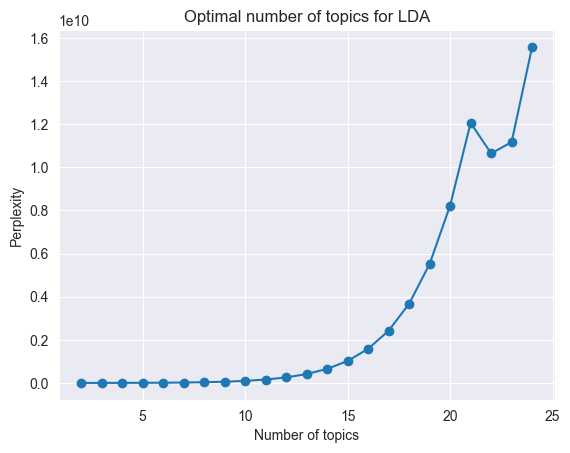

In [52]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

perplexity_scores = []
topic_range = range(2, 25)

for n_topics in topic_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(df_lemm_vectorized)
    perplexity_scores.append(lda.perplexity(df_lemm_vectorized))

plt.plot(topic_range, perplexity_scores, marker='o')
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.title("Optimal number of topics for LDA")
plt.show()

на графике видно, что perplexity остаётся низкой до примерно 10–12 тем, а затем начинает резко расти

- оптимальное кол-во тем для LDA обычно выбирается перед точкой резкого роста, поэтому выборем 12 тем, это обеспечит хорошую интерпретируемость

In [53]:
lda = LatentDirichletAllocation(
    n_components=12, 
    random_state=42,
    learning_method='online',
    batch_size=128,
    max_iter=20,
    evaluate_every=5,
)

lda_topics = lda.fit_transform(df_lemm_vectorized)